# Анализ результатов А/В тестов

<b>Условие:</b>
    В апреле - мае 2017 года внедрялась новая форма оформления заказа, была осуществлена замена многостраничной формы на одностраничную. Переход проходил поэтапно, через череду А/В тестов и откатов к прежним версиям для фиксации критических багов. К концу мая одностраничная форма была внедрена окончательно. На базе имеющихся данных определить изменилась ли конверсия в связи с этим переходом. Если эффект был, то дать оценку. Выводы с обоснованием предоставить в виде аналитической записки лидеру проекта. Никаких ограничений по форме представления информации нет.


<b>Вопрос:</b>
    Изменилась ли конверсия в связи с переходом на однострунную форму оформления заказа?

In [1]:
# Импортируем необходимые библиотеки для анализа
import pandas as pd
from datetime import date, timedelta, datetime
import numpy as np
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt

In [2]:
# Загружаем данные для анализа в формате DataFrame
data = pd.read_csv('test results.csv', parse_dates=['date'], low_memory=False)

## Первичный визуальный анализ данных

Для начала проведем первичный анализ имеющихся данных:

In [3]:
# Первые пять строк
data[:5]

,date,deviceCategory,fullVisitorId,visitNumber,channelGrouping,event,action
0,2017-09-28,mobile,1979366526314401785,2,SEO - Other,CartAdd,Click
1,2017-06-06,mobile,1492087041879793949,2,SEO - Other,CartAdd,Click
2,2017-01-14,mobile,9100021380756962686,1,SEO - Other,CartAdd,Click
3,2017-04-24,mobile,7257037062782464707,1,SEO - Other,CartAdd,Click
4,2017-03-13,mobile,3395570264884561101,52,Retargeting - Yandex,CartAdd,Click


In [4]:
# Последние пять строк
data[-5:]

,date,deviceCategory,fullVisitorId,visitNumber,channelGrouping,event,action
7602638,2018-03-21,desktop,7782288507698299130,220,Context - Yandex Not Brand,Ecommerce,Checkout
7602639,2017-08-04,desktop,5513994499173912352,121,Context - Yandex Not Brand,Ecommerce,Checkout
7602640,2017-06-03,desktop,6992841766004254403,2,Context - Yandex Not Brand,Ecommerce,Checkout
7602641,2017-07-04,desktop,7494853280322250454,3,Context - Yandex Not Brand,Ecommerce,Checkout
7602642,2017-09-26,desktop,6794031371995013210,16,Context - Yandex Not Brand,Ecommerce,Checkout


Не все данные необходимы для анализа, поэтому удалим лишние, а именно:
* fullVisitorId
* deviceCategory
* visitNumber
* channelGrouping

In [5]:
# Удалим не нужные для анализа столбцы channelGrouping, visitNumber, deviceCategory, fullVisitorId
data.drop('fullVisitorId', 1, inplace=True)
data.drop('channelGrouping', 1, inplace=True)
data.drop('visitNumber', 1, inplace=True)
data.drop('deviceCategory', 1, inplace=True)

Чтобы определить за какой период времени данные мы имеем, отсортируем их по дате

In [6]:
# Отсортируем по дате
data.sort_values(by='date', inplace=True)

Снова посмотрим на первые и последние строчки

In [7]:
# Первые пять строк
data[:5]

,date,event,action
2661853,2017-01-01,landing,NaN
5082066,2017-01-01,CartView,Click
5082140,2017-01-01,CartView,Click
370753,2017-01-01,CartAdd,Click
7395395,2017-01-01,Ecommerce,Checkout


In [8]:
# Последние пять строк
data[-5:]

,date,event,action
5369019,2018-03-31,CartView,Click
2512926,2018-03-31,landing,NaN
5169810,2018-03-31,CartView,Click
5049550,2018-03-31,CartView,Click
5796779,2018-03-31,Ecommerce,Checkout


Видим что данные представлены за период с 1 декабря 2017 годя по 31 марта 2018 года включительно.

Нас интересуют значения в категория "event" и "action". Поэтому посмотрим на количественный состав значений в этих категориях

In [9]:
events = data['event'].value_counts()
actions = data['action'].value_counts()

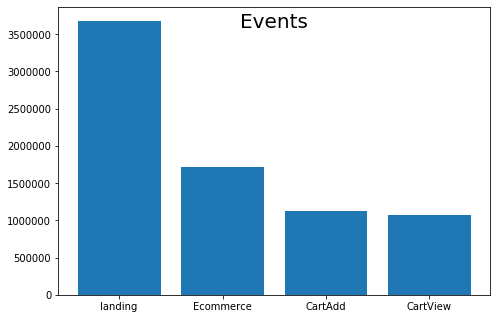

In [10]:
bar_ev = plt.figure()
bar_ev.suptitle('Events', fontsize=20)
ax_bar_ev = bar_ev.add_axes([0,0,1,1])
ax_bar_ev.bar(events.index, events.values)
plt.show()

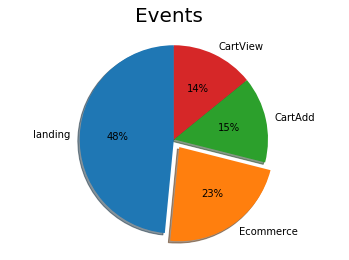

In [11]:
pie_ev, ax_pie_ev = plt.subplots()
pie_ev.suptitle('Events', fontsize=20)
ax_pie_ev.pie(events.values, explode=(0, 0.1, 0, 0), labels=events.index,
        autopct='%1.0f%%', shadow=True, startangle=90)
ax_pie_ev.axis('Equal')

plt.show()

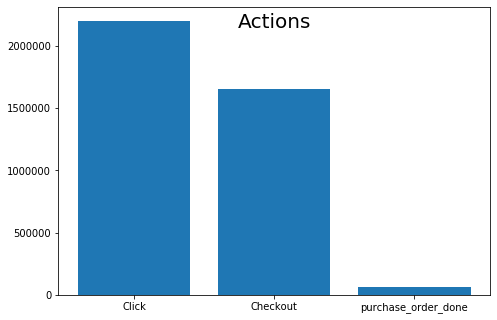

In [12]:
bar_act = plt.figure()
bar_act.suptitle('Actions', fontsize=20)
ax_bar_act = bar_act.add_axes([0,0,1,1])
ax_bar_act.bar(actions.index, actions.values)
plt.show()

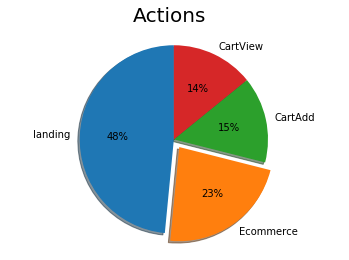

In [13]:
pie_act, ax_pie_act = plt.subplots()
pie_act.suptitle('Actions', fontsize=20)
ax_pie_act.pie(events.values, explode=(0, 0.1, 0, 0), labels=events.index,
        autopct='%1.0f%%', shadow=True, startangle=90)
ax_pie_act.axis('Equal')

plt.show()

#### Видим следущие значения в категориях:
<b>События:</b>
* landing - переход на сайт
* cartAdd - добавить в корзину
* cartView - переход в корзину

<b>Действия:</b>
* click - действие пользователя
* checkout - оформление заказа
* purchase_order_done - заказ на покупку

Конверсию будем попределять как соотношение количества заказов к числу переходов на сайт в процентах т.е.

<b>("purchase_order_done"/"landing")*100 - конверсия</b>

## Новые данные для анализа

<b>Создадим следующие данные для анализа:</b>
* Словарь по дням, где для каждого дня запишем количество каждого из событий
* Словарь по дням, где для каждого дня запишем количество каждого из действий
* Словарь по дням, где для каждого дня запишем значение конверсии

Все словари для более удобной работы представим в формате DataFrame

In [15]:
# Частотный словарь по дням для действий
actions_dict = {}
for index in range(len(data)):
    if data.loc[index, 'date'] not in actions_dict:
        actions_dict[data.loc[index, 'date']] = [0, 0, 0]
    if data.loc[index, 'action'] == 'Click':
        actions_dict[data.loc[index, 'date']][0] += 1
    elif data.loc[index, 'action'] == 'Checkout':
        actions_dict[data.loc[index, 'date']][1] += 1
    elif data.loc[index, 'action'] == 'purchase_order_done':
        actions_dict[data.loc[index, 'date']][2] += 1

In [16]:
# Преобразуем словарь в DataFrame с удобным обозначение столбцов
actions_df = pd.DataFrame.from_dict(actions_dict, orient='index').reset_index()
actions_df.rename(columns={'index': 'date', 0: 'click', 1: 'checkout', 2: 'done'}, inplace=True)

In [16]:
actions_df[:2]

action,Checkout,Click,purchase_order_done
date,,,
2017-01-01,1332,1629,47
2017-01-02,1717,2798,59


In [17]:
data['action'] = data['action'].replace({pd.np.nan: 'No_action'})

In [18]:
data['action']

2661853    No_action
5082066        Click
5082140        Click
370753         Click
7395395     Checkout
             ...    
5369019        Click
2512926    No_action
5169810        Click
5049550        Click
5796779     Checkout
Name: action, Length: 7602643, dtype: object

In [19]:
actions_df = data.pivot_table(index='date', columns='action', aggfunc='count', fill_value=0)
actions_df = actions_df['event']

In [20]:
actions_df[:2]

action,Checkout,Click,No_action,purchase_order_done
date,,,,
2017-01-01,1332,1629,3686,47
2017-01-02,1717,2798,4470,59


In [26]:
data.groupby(['date'])['event'].aggregate('count')

date
2017-01-01     6694
2017-01-02     9044
2017-01-03     9940
2017-01-04    11346
2017-01-05    11573
              ...  
2018-03-27    19565
2018-03-28    19562
2018-03-29    21242
2018-03-30    19233
2018-03-31    17685
Name: event, Length: 455, dtype: int64

In [131]:
# Частотный словарь по дням для событий
events_dict = {}
for index in range(len(data)):
    if data.loc[index, 'date'] not in events_dict:
        events_dict[data.loc[index, 'date']] = [0, 0, 0, 0]
    if data.loc[index, 'event'] == 'landing':
        events_dict[data.loc[index, 'date']][0] += 1
    elif data.loc[index, 'event'] == 'Ecommerce':
        events_dict[data.loc[index, 'date']][1] += 1
    elif data.loc[index, 'event'] == 'CartAdd':
        events_dict[data.loc[index, 'date']][2] += 1
    elif data.loc[index, 'event'] == 'CartView':
        events_dict[data.loc[index, 'date']][3] += 1

In [132]:
events_dict

{Timestamp('2017-09-28 00:00:00'): [8555, 4523, 2747, 2386],
 Timestamp('2017-06-06 00:00:00'): [8105, 2727, 2342, 2204],
 Timestamp('2017-01-14 00:00:00'): [6922, 2623, 2070, 1650],
 Timestamp('2017-04-24 00:00:00'): [8059, 1887, 2434, 2451],
 Timestamp('2017-03-13 00:00:00'): [8145, 3779, 2196, 2622],
 Timestamp('2017-09-15 00:00:00'): [7694, 4085, 2574, 2361],
 Timestamp('2017-01-12 00:00:00'): [7863, 3550, 2581, 2037],
 Timestamp('2018-02-15 00:00:00'): [10388, 5917, 3383, 3434],
 Timestamp('2017-01-26 00:00:00'): [7910, 4075, 2382, 2604],
 Timestamp('2017-10-17 00:00:00'): [9500, 4772, 2852, 2678],
 Timestamp('2017-09-14 00:00:00'): [8282, 4628, 2638, 2604],
 Timestamp('2018-01-22 00:00:00'): [9704, 5035, 2965, 2856],
 Timestamp('2017-10-18 00:00:00'): [8808, 4312, 2756, 2363],
 Timestamp('2018-02-03 00:00:00'): [8668, 4015, 2653, 2266],
 Timestamp('2017-10-11 00:00:00'): [9375, 4878, 3208, 2773],
 Timestamp('2017-06-01 00:00:00'): [7296, 2566, 2206, 2082],
 Timestamp('2017-09-06 

In [133]:
# Преобразуем словарь в DataFrame с удобным обозначение столбцов
events_df = pd.DataFrame.from_dict(events_dict, orient='index').reset_index()
events_df.rename(columns={'index': 'date', 0: 'landing', 1: 'ecommerce', 2: 'cartView', 3: 'cartAdd'}, inplace=True)

In [134]:
events_df

,date,landing,ecommerce,cartView,cartAdd
0,2017-09-28,8555,4523,2747,2386
1,2017-06-06,8105,2727,2342,2204
2,2017-01-14,6922,2623,2070,1650
3,2017-04-24,8059,1887,2434,2451
4,2017-03-13,8145,3779,2196,2622
...,...,...,...,...,...
450,2017-07-27,6536,2994,1710,1752
451,2017-05-07,5344,1181,1621,1525
452,2017-01-01,3686,1379,746,883
453,2017-01-02,4470,1776,1692,1106


In [18]:
# Словарь размера конверсии по дням
conversion_dict = {}
for index in range(len(events_df)):
    conversion_dict[events_df.loc[index, 'date']] = (float(actions_df.loc[index, 'done'])/events_df.loc[index, 'landing'])*100

In [19]:
# Преобразуем словарь в DataFrame с удобным обозначение столбцов
conversion_df = pd.DataFrame.from_dict(conversion_dict, orient='index').reset_index()
conversion_df.rename(columns={'index': 'date', 0: 'conversion'}, inplace=True)

Посмотрим как выглядят и как распределены необходимые нам данные с конверсией по дням

In [20]:
conversion_df.head()

,date,conversion
0,2017-07-11,1.817673
1,2018-01-11,1.822863
2,2017-02-15,2.319098
3,2017-11-05,1.523784
4,2017-04-23,1.697037


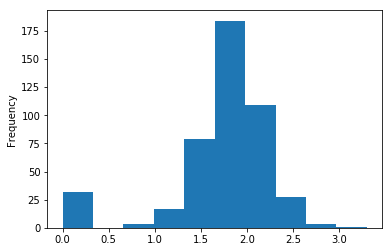

In [21]:
conversion_df['conversion'].plot(kind='hist')

Видим по графику что интересующие нас данные по значению конверсии небольшие отклонения от нормально распределения. Для улучшения качества анализа нормализуем данные, а именно дни с конверсией менее 0.5 и более 3

In [22]:
conversion_df.drop(conversion_df[conversion_df.conversion > 3].index, inplace=True)
conversion_df.drop(conversion_df[conversion_df.conversion < 0.5].index, inplace=True)

Чтобы определить насколько внедрение одностраничной формы оформления заказа повлияло на конверсии, разделим данные на три части:
* До начала внедрения одностраничной формы оформления заказа(с 1 декабря 2017 по 31 марта 2017 года)
* Во время внедрения и тестирования(с 1 апреля 2017 по 31 мая 2017 года)
* После окончательного внедрения(с 1 июня 2017 по 31 марта 2018 года)

Итого, получатся что мы имеем данные: 
* за три месяца до начала внедрения новой формы оформления заказа
* два месяца во время внедрения и тестирования
* семь месяцев после внедрения

In [23]:
start = datetime(2017,4,1) # день начала внеднерия одностраничной формы
end = datetime(2017,6,1) # день окончательного внедрения

# DF событий разделенный на части до изменений, во время введения и после внесения изменений
beforeTestEvents = events_df.drop(events_df[events_df.date >= start].index)
timeTestEvents = events_df.drop(events_df[events_df.date < start].index)
timeTestEvents.drop(timeTestEvents[timeTestEvents.date >= end].index, inplace=True)
afterTestEvents = events_df.drop(events_df[events_df.date < end].index)

# DF действий разделенный на части до изменений, во время введения и после внесения изменений
beforeTestActions = actions_df.drop(actions_df[actions_df.date >= start].index)
timeTestActions = actions_df.drop(actions_df[actions_df.date < start].index)
timeTestActions.drop(timeTestActions[timeTestActions.date >= end].index, inplace=True)
afterTestActions = actions_df.drop(actions_df[actions_df.date < end].index)

# DF конверсии разделенный на части до изменений, во время введения и после внесения изменений
beforeTestConversion = conversion_df.drop(conversion_df[conversion_df.date >= start].index)
timeTestConversion = conversion_df.drop(conversion_df[conversion_df.date < start].index)
timeTestConversion.drop(timeTestConversion[timeTestConversion.date >= end].index, inplace=True)
afterTestConversion = conversion_df.drop(conversion_df[conversion_df.date < end].index)

In [24]:
beforeTestConversion.describe()

,conversion
count,89.000000
mean,1.808453
std,0.309589
min,0.966635
25%,1.613286
50%,1.839991
75%,1.965632
max,2.811720


In [25]:
timeTestConversion.describe()

,conversion
count,61.000000
mean,1.770797
std,0.264911
min,0.877653
25%,1.641108
50%,1.778711
75%,1.943761
max,2.453444


In [26]:
afterTestConversion.describe()

,conversion
count,272.000000
mean,1.896606
std,0.311895
min,0.856758
25%,1.729396
50%,1.891586
75%,2.102213
max,2.707276


In [27]:
afterTestConversion.mean().conversion

1.8966060800280942

In [28]:
print "Разница между средними в процентах от значения до внедрения:", (afterTestConversion.mean().conversion - beforeTestConversion.median().conversion)/beforeTestConversion.median().conversion*100

Разница между средними в процентах от значения до внедрения: 3.0769392987420567


In [29]:
print "Разница между медианами в процентах от значения до внедрения:", (afterTestConversion.median().conversion - beforeTestConversion.median().conversion)/beforeTestConversion.median().conversion*100

Разница между медианами в процентах от значения до внедрения: 2.8041174991793234


По полученным данным видим что конверсия в период после внедрения одностраничной формы оформления заказа увеличилась в среднем на 3 процента. Теперь статистически проверим гипотезу о том что внедрение новой формы действительно повлияло на конверсию.

## Доверительные интервалы на основе bootstrap

In [30]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [31]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Построим доверительные интервалы для медиан и средних значений конверсии до внедрения и после.

#### Интервальная оценка медианы

In [32]:
# Доверительные интервалы для медиан
np.random.seed(0)

before_median_conversion = map(np.median, get_bootstrap_samples(beforeTestConversion['conversion'].values, 500))
after_median_conversion = map(np.median, get_bootstrap_samples(afterTestConversion['conversion'].values , 500))

print "95% доверительный интервал для значений медианы конверсии до внедрения:", stat_intervals(before_median_conversion , 0.05)
print "95% доверительный интервал для значений медианы конверсии после внедрения:", stat_intervals(after_median_conversion , 0.05)

95% доверительный интервал для значений медианы конверсии до внедрения: [1.74496644 1.87340335]
95% доверительный интервал для значений медианы конверсии после внедрения: [1.83794061 1.92895779]


####  Интервальная оценка средних

In [33]:
# Доверительные интервалы для средних
np.random.seed(0)

before_mean_conversion = map(np.mean, get_bootstrap_samples(beforeTestConversion['conversion'].values, 500))
after_mean_conversion = map(np.mean, get_bootstrap_samples(afterTestConversion['conversion'].values , 500))

print "95% доверительный интервал для значений средней конверсии до внедрения:", stat_intervals(before_mean_conversion , 0.05)
print "95% доверительный интервал для значений средней конверсии после внедрения:", stat_intervals(after_mean_conversion , 0.05)

95% доверительный интервал для значений средней конверсии до внедрения: [1.73585043 1.86264674]
95% доверительный интервал для значений средней конверсии после внедрения: [1.85854921 1.93775623]


#### Интервальная оценка разности медиан

In [34]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(before_median_conversion, after_median_conversion))
print "95% доверительный интервал для разности между медианами",  stat_intervals(delta_median_scores, 0.05)

95% доверительный интервал для разности между медианами [-0.0122582   0.16522529]


#### Интервальная оценка разности средних

In [35]:
delta_mean_scores = map(lambda x: x[1] - x[0], zip(before_mean_conversion, after_mean_conversion))
print "95% доверительный интервал для разности между средними",  stat_intervals(delta_mean_scores, 0.05)

95% доверительный интервал для разности между средними [0.01790304 0.16916526]


Поскольку данные распределены нормально можно воспользоваться критерием Манна — Уитни для выявления достоверности различия между значениями параметра в выборках

#### Оценка различий между данными до и после при помощи критерия Манна — Уитни

In [36]:
statistic, pvalue = stats.mannwhitneyu(beforeTestConversion['conversion'].values, afterTestConversion['conversion'].values)
print "Критерий Манна — Уитни", pvalue

Критерий Манна — Уитни 0.008611214332858146


Чем меньше значение критерия, тем вероятнее, что различия между значениями параметра в выборках достоверны.

Чтобы удостовериться в полученных данных проведем коррекцию на множественное тестирование

#### Поправка Холма-Бонферрони

Сделаем поправку Холма-Бонферрони на множественную проверку с α = 0.01

In [37]:
reject, p_corrected, a1, a2 = multipletests(pvalue, alpha = 0.01, method = 'bonferroni')
print(reject)
print(p_corrected)

[ True]
[0.00861121]


Видим что вероятность появления ошибки достаточно мала

При анализе данных были проделаны следующие шаги:
1. Визуальная оценка полученных данных
2. Отбор необходимых и формирование пригодных для анализа данных
3. Построение выводов об изменениях после внедрения новой формы оформления заказа
4. Оценка значимости полученных данных

В итоге видим, что изменния в конверсии статистически значимы. Значит на основании данного анализа можно утверждать:
* <b>Конверсия после внедрения одностраничной формы оформления заказа выросла примерно на 3 процента</b>